<a href="https://colab.research.google.com/github/pouyapanahandeh/detecron2/blob/main/assignment_3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

     |████████████████████████████████| 274 kB 5.4 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=b66f9fe8f13535d1dbe3cca3ce1a57499e6a06467c12e87fcf45f58d54b4458f
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 737 kB/s 
     |████████████████████████████████| 49 kB 887 kB/s 
     |████████████████████████████████| 145 kB 10.9 MB/s 
     |████████████████████████████████| 130 kB 52.8 MB/s 
     |████████████████████████████████| 74 kB 3.5 MB/s 
     |████████████████████████████████| 843 kB 49.2 MB/s 
     |███████████████████████████████

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
# download data from gh
!wget https://github.com/pouyapanahandeh/detecron2/raw/main/car.zip
!unzip car.zip > /dev/null

--2022-01-09 18:43:10--  https://github.com/pouyapanahandeh/detecron2/raw/main/car.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pouyapanahandeh/detecron2/main/car.zip [following]
--2022-01-09 18:43:11--  https://raw.githubusercontent.com/pouyapanahandeh/detecron2/main/car.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11119086 (11M) [application/zip]
Saving to: ‘car.zip’

car.zip             100%[===================>]  10.60M  --.-KB/s    in 0.1s    

2022-01-09 18:43:13 (110 MB/s) - ‘car.zip’ saved [11119086/11119086]



In [ ]:
json_file = os.path.join("car/train", "via_project.json")

In [ ]:
json_file

In [ ]:
with open(json_file) as f:
    imgs_anns = json.load(f)

In [ ]:
imgs_anns.keys()

In [ ]:
imgs_anns["00002.jpeg257088"].keys()

In [ ]:
imgs_anns["00002.jpeg257088"]["regions"].keys()

In [ ]:
imgs_anns["00002.jpeg257088"]["regions"]["region_attributes"]

In [ ]:
imgs_anns["00030.jpg57984"]["regions"]["region_attributes"]

In [ ]:
imgs_anns["00044.jpeg92219"]["regions"]["region_attributes"]

In [ ]:
imgs_anns['00078.jpeg70245']["regions"]["region_attributes"]

In [ ]:
import pandas as pd

In [ ]:
for i in imgs_anns.keys():
  print(imgs_anns[i]["regions"]["region_attributes"])

In [4]:
from detectron2.structures import BoxMode

def get_car_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_project.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                #"segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("car_" + d, lambda d=d: get_car_dicts("car/" + d))
    MetadataCatalog.get("car_" + d).set(thing_classes=["car"])
car_metadata = MetadataCatalog.get("car_train")

In [5]:
dataset_dicts = get_car_dicts("car/train")
dataset_dicts

[{'annotations': [{'bbox': [67, 140, 836, 577],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}],
  'file_name': 'car/train/00002.jpeg',
  'height': 675,
  'image_id': 0,
  'width': 900},
 {'annotations': [{'bbox': [85, 111, 871, 523],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}],
  'file_name': 'car/train/00030.jpg',
  'height': 592,
  'image_id': 1,
  'width': 896},
 {'annotations': [{'bbox': [219, 114, 660, 397],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}],
  'file_name': 'car/train/00040.jpg',
  'height': 469,
  'image_id': 2,
  'width': 750},
 {'annotations': [{'bbox': [222, 191, 535, 364],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}],
  'file_name': 'car/train/00044.jpeg',
  'height': 439,
  'image_id': 3,
  'width': 659},
 {'annotations': [{'bbox': [23, 22, 421, 261],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}],
  'file_name': 'car/train/00062.jpg',
  'height': 280,
  'image_id': 4,
  'width'

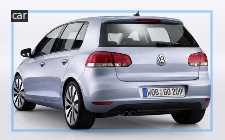

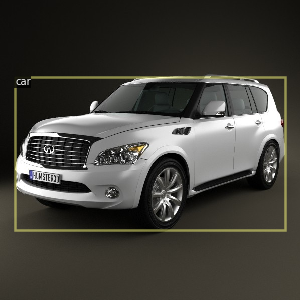

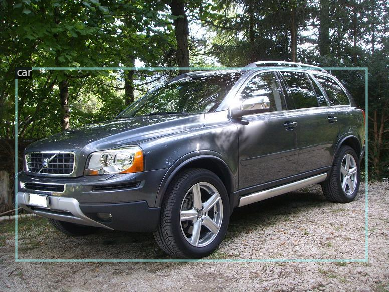

In [6]:

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=car_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [7]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/09 18:43:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:03, 43.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pre

[01/09 18:44:04 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/09 18:44:36 d2.utils.events]:  eta: 0:07:36  iter: 19  total_loss: 1.143  loss_cls: 0.7124  loss_box_reg: 0.4539  loss_rpn_cls: 0.004019  loss_rpn_loc: 0.003994  time: 1.5710  data_time: 0.0276  lr: 1.6068e-05  max_mem: 2622M
[01/09 18:45:07 d2.utils.events]:  eta: 0:06:40  iter: 39  total_loss: 0.9918  loss_cls: 0.5354  loss_box_reg: 0.4365  loss_rpn_cls: 0.002827  loss_rpn_loc: 0.003953  time: 1.5594  data_time: 0.0096  lr: 3.2718e-05  max_mem: 2639M
[01/09 18:45:37 d2.utils.events]:  eta: 0:06:10  iter: 59  total_loss: 0.7979  loss_cls: 0.348  loss_box_reg: 0.4623  loss_rpn_cls: 0.006867  loss_rpn_loc: 0.003462  time: 1.5487  data_time: 0.0085  lr: 4.9367e-05  max_mem: 2675M
[01/09 18:46:09 d2.utils.events]:  eta: 0:05:39  iter: 79  total_loss: 0.7498  loss_cls: 0.2563  loss_box_reg: 0.4714  loss_rpn_cls: 0.003045  loss_rpn_loc: 0.00355  time: 1.5566  data_time: 0.0089  lr: 6.6017e-05  max_mem: 2675M
[01/09 18:46:40 d2.utils.events]:  eta: 0:05:07  iter: 99  total_loss: 0.6442  

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


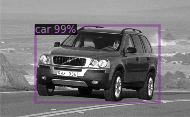

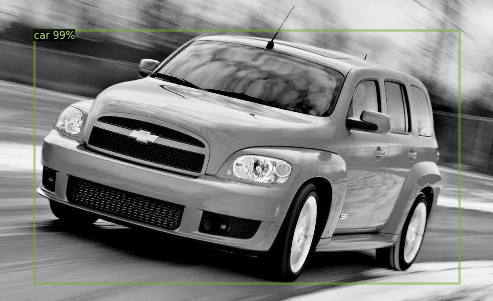

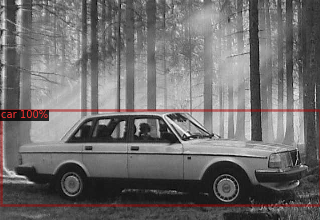

In [9]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_car_dicts("car/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=car_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [10]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("car_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "car_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[01/09 18:54:02 d2.evaluation.coco_evaluation]: Trying to convert 'car_val' to COCO format ...
[01/09 18:54:02 d2.data.datasets.coco]: Converting annotations of dataset 'car_val' to COCO format ...)
[01/09 18:54:02 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/09 18:54:02 d2.data.datasets.coco]: Conversion finished, #images: 33, #annotations: 33
[01/09 18:54:02 d2.data.datasets.coco]: Caching COCO format annotations at './output/car_val_coco_format.json' ...
[01/09 18:54:02 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    car     | 33           |
|            |              |
[01/09 18:54:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/09 18:54:02 d2.data.common]: Serializing 33 elements to byte tensors and concatenating them all ...
[01/09 18:54:02 d2.data.comm

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[01/09 18:54:07 d2.evaluation.evaluator]: Inference done 11/33. Dataloading: 0.0020 s/iter. Inference: 0.4464 s/iter. Eval: 0.0003 s/iter. Total: 0.4487 s/iter. ETA=0:00:09
[01/09 18:54:12 d2.evaluation.evaluator]: Inference done 23/33. Dataloading: 0.0023 s/iter. Inference: 0.4368 s/iter. Eval: 0.0003 s/iter. Total: 0.4395 s/iter. ETA=0:00:04
[01/09 18:54:17 d2.evaluation.evaluator]: Total inference time: 0:00:12.351542 (0.441126 s / iter per device, on 1 devices)
[01/09 18:54:17 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:12 (0.436396 s / iter per device, on 1 devices)
[01/09 18:54:17 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/09 18:54:17 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/09 18:54:17 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/09 18:54:17 d2.evaluation.f